# Stable Diffusion 1.5

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/sd.ipynb)

Includes DeepCache and Compel.

Flash Attention v2 should work automatically on PyTorch 2.2+ with Ampere and newer GPUs. I'm not using xformers since PyTorch 2 has scaled dot product attention (SDPA) enabled by default. I'm also not using attention slicing, as it's not compatible with SDPA.

In [1]:
# @title Install
import os
import sys
import subprocess
from importlib.util import find_spec

modules = ["accelerate", "compel", "DeepCache", "diffusers", "hf_transfer", "transformers"]  # case sensitive
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# @title Imports
import gc
import os
from datetime import datetime
from hashlib import md5
from io import BytesIO
from warnings import filterwarnings

import torch
from PIL import Image
from compel import Compel, ReturnedEmbeddingsType
from compel.prompt_parser import PromptParser
from DeepCache import DeepCacheSDHelper
from diffusers import (
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    DEISMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionPipeline,
    UniPCMultistepScheduler,
)
from transformers import logging

In [3]:
# @title Environment
try:
    from google.colab import userdata

    HF_TOKEN = userdata.get("HF_TOKEN")
except ImportError:
    HF_TOKEN = os.environ.get("_HF_TOKEN", None) or os.environ.get("HF_TOKEN", "")
finally:
    os.environ["HF_TOKEN"] = HF_TOKEN
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

filterwarnings("ignore", category=FutureWarning, module="diffusers")
filterwarnings("ignore", category=FutureWarning, module="transformers")
logging.set_verbosity_error()

In [4]:
# @title Pipeline
class Loader:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.pipe = None
            cls._instance.model = None
        return cls._instance

    def _flush(self):
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    def _should_unload_pipeline(self, model):
        if self.pipe is None:
            return False
        if self.model.lower() != model.lower():
            return True
        return False

    def _load_pipeline(self, model, cpu_offload, **kwargs):
        if self.pipe is None:
            print(f"Loading {model}...")
            self.model = model
            self.pipe = StableDiffusionPipeline.from_pretrained(model, **kwargs)
            if cpu_offload:
                self.pipe.enable_model_cpu_offload()
            else:
                self.pipe.to("cuda")

    def _load_deepcache(self, interval=1):
        has_deepcache = hasattr(self.pipe, "deepcache")
        if has_deepcache and self.pipe.deepcache.params["cache_interval"] == interval:
            return
        if has_deepcache:
            self.pipe.deepcache.disable()
        else:
            self.pipe.deepcache = DeepCacheSDHelper(pipe=self.pipe)
        self.pipe.deepcache.set_params(cache_interval=interval)
        self.pipe.deepcache.enable()

    def _unload(self, model):
        items = []
        if self._should_unload_pipeline(model):
            items.append("pipe")
            items.append("model")
        for item in items:
            delattr(self, items)
        self._flush()
        for item in items:
            setattr(self, item, None)

    def load(self, model, scheduler, karras, deepcache, cpu_offload):
        schedulers = {
            "DDIM": DDIMScheduler,
            "DEIS 2M": DEISMultistepScheduler,
            "DPM++ 2M": DPMSolverMultistepScheduler,
            "Euler": EulerDiscreteScheduler,
            "Euler a": EulerAncestralDiscreteScheduler,
            "PNDM": PNDMScheduler,
            "UniPC 2M": UniPCMultistepScheduler,
        }
        scheduler_kwargs = {
            "beta_start": 0.00085,
            "beta_end": 0.012,
            "beta_schedule": "scaled_linear",
            "timestep_spacing": "leading",
            "steps_offset": 1,
        }

        if scheduler not in ["DDIM", "Euler a", "PNDM"]:
            scheduler_kwargs["use_karras_sigmas"] = karras

        # https://github.com/huggingface/diffusers/blob/8a3f0c1/scripts/convert_original_stable_diffusion_to_diffusers.py#L939
        if scheduler == "DDIM":
            scheduler_kwargs["clip_sample"] = False
            scheduler_kwargs["set_alpha_to_one"] = False

        device = torch.device("cuda")
        dtype = torch.bfloat16 if torch.cuda.get_device_properties(device).major >= 8 else torch.float16
        pipe_kwargs = {
            "variant": "fp16",
            "torch_dtype": dtype,
            "safety_checker": None,
            "requires_safety_checker": False,
            "scheduler": schedulers[scheduler](**scheduler_kwargs),
        }

        self._unload(model)
        self._load_pipeline(model, cpu_offload, **pipe_kwargs)

        # error
        if self.pipe is None:
            return

        same_scheduler = isinstance(self.pipe.scheduler, schedulers[scheduler])
        same_karras = (
            not hasattr(self.pipe.scheduler.config, "use_karras_sigmas")
            or self.pipe.scheduler.config.use_karras_sigmas == karras
        )

        if self.model.lower() == model.lower():
            if not same_scheduler:
                print(f"Switching to {scheduler}...")
            if not same_karras:
                print(f"{'Enabling' if karras else 'Disabling'} Karras sigmas...")
            if not same_scheduler or not same_karras:
                self.pipe.scheduler = schedulers[scheduler](**scheduler_kwargs)

        self._load_deepcache(deepcache)

In [5]:
# @title Inference
def main():
    global \
        MODEL, \
        SCHEDULER, \
        PROMPT, \
        NEGATIVE_PROMPT, \
        OUT_DIR, \
        SEED, \
        WIDTH, \
        HEIGHT, \
        GUIDANCE_SCALE, \
        INFERENCE_STEPS, \
        DEEPCACHE, \
        KARRAS, \
        CLIP_SKIP, \
        CPU_OFFLOAD

    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available")

    if SEED is None or SEED < 0:
        seed = int(datetime.now().timestamp() * 1e6) % (2**64)
    else:
        seed = SEED

    embeddings_type = (
        ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NORMALIZED
        if CLIP_SKIP
        else ReturnedEmbeddingsType.LAST_HIDDEN_STATES_NORMALIZED
    )

    loader = Loader()
    loader.load(MODEL, SCHEDULER, KARRAS, DEEPCACHE, CPU_OFFLOAD)

    # error
    if loader.pipe is None:
        return

    pipe = loader.pipe

    compel = Compel(
        device=pipe.device,
        tokenizer=pipe.tokenizer,
        truncate_long_prompts=False,
        text_encoder=pipe.text_encoder,
        returned_embeddings_type=embeddings_type,
        dtype_for_device_getter=lambda _: pipe.dtype,
    )

    try:
        pos_embeds = compel(PROMPT)
        neg_embeds = compel(NEGATIVE_PROMPT)
        pos_embeds, neg_embeds = compel.pad_conditioning_tensors_to_same_length([pos_embeds, neg_embeds])
    except PromptParser.ParsingException:
        print("Invalid prompt")
        return

    try:
        image = pipe(
            width=WIDTH,
            height=HEIGHT,
            prompt_embeds=pos_embeds,
            guidance_scale=GUIDANCE_SCALE,
            negative_prompt_embeds=neg_embeds,
            num_inference_steps=INFERENCE_STEPS,
            generator=torch.Generator(device=pipe.device).manual_seed(seed),
        ).images[0]
    except Exception as e:
        print(e)
        return

    image_file = save_image(image, OUT_DIR)
    print(image_file)
    display(Image.open(image_file))


# save image using content-based hash
def save_image(image, out_dir="."):
    image_bytes = BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes.seek(0)
    image_hash = md5(image_bytes.read()).hexdigest()
    filename = f"{out_dir}/{image_hash}.png"
    image.save(filename)
    return filename

Loading Lykon/dreamshaper-8...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

./c38d0e81cd0a8915f27c7ef274f45584.png


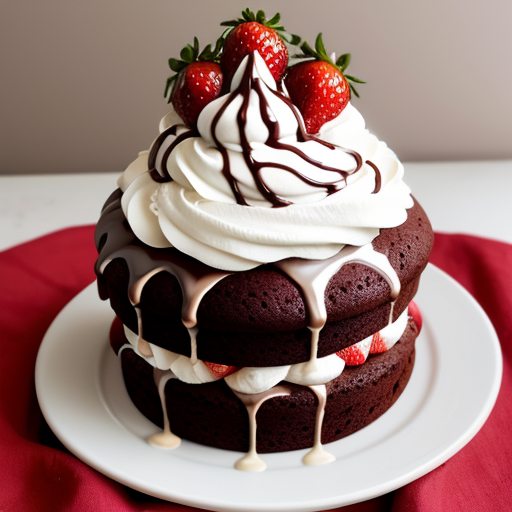

In [6]:
# fmt: off
MODEL = "Lykon/dreamshaper-8"  # @param {type: "string"}
SCHEDULER = "Euler"  # @param {type: "string"} ["DDIM", "DEIS 2M", "DPM++ 2M", "Euler", "Euler a", "PNDM", "UniPC 2M"]
PROMPT = "chocolate (cake)1.1, topped with whipped cream and strawberries, garnished with chocolate drizzle, food photography, fresh, delicious, culinary, macro details, soft lighting, real, authentic, high resolution, uhd"  # @param {type: "string"}
NEGATIVE_PROMPT = "watermark, trademark, signature, autograph, artifacts, deformed, mutated, fake, artificial, bad, ugly, unattractive, unappetizing, noisy, grainy, blurry, distorted, oversaturated, undersaturated, overexposed, underexposed, amateur, sloppy, cluttered, low detail, worst quality"  # @param {type: "string"}
SEED = 400369051  # @param {type: "integer", min: -1, max: 18446744073709551615}
OUT_DIR = "."  # @param {type: "string"}
WIDTH = 512  # @param {type: "slider", min: 256, max: 768, step: 32}
HEIGHT = 512  # @param {type: "slider", min: 256, max: 768, step: 32}
GUIDANCE_SCALE = 6  # @param {type: "slider", min: 0, max: 15, step: 0.1}
INFERENCE_STEPS = 35  # @param {type: "slider", min: 1, max: 50}
DEEPCACHE = 1  # @param {type: "slider", min: 1, max: 4}
KARRAS = True  # @param {type: "boolean"}
CLIP_SKIP = False  # @param {type: "boolean"}
CPU_OFFLOAD = True  # @param {type: "boolean"}
main()